<a href="https://colab.research.google.com/github/zakirangwala/esrb-wrizard/blob/main/notebooks/exploratory_analysis.ipynb" target="_parent">
    <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

# Steam + ESRB Exploratory Analysis

This notebook validates the merged dataset (`data/processed/merged_dataset.csv`) and builds intuition for modeling average playtime using Steam metadata, ESRB maturity signals, Steam achievement engagement, and IGDB descriptors.

### Notebook Goals
- Confirm schema, data types, and missing-value patterns after the data pipeline run.
- Create sanity-check visuals (distributions, correlations, ESRB coverage, engagement vs pricing).
- Surface IGDB descriptor coverage and the most common genres/tags to guide feature engineering.
- Provide ready-to-use feature columns for downstream modeling notebooks.

In [7]:
from __future__ import annotations

import math
from collections import Counter
from pathlib import Path

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import display

sns.set_theme(style="whitegrid", context="talk")
pd.options.display.float_format = "{:,.2f}".format

DATA_PATH = Path("/Users/zakirangwala/Desktop/esrb-wrizard/data/processed/merged_dataset.csv")
RANDOM_STATE = 42

In [9]:
NUMERIC_COLS = [
    "price_usd",
    "user_score",
    "reviews_positive",
    "reviews_negative",
    "avg_playtime_forever",
    "median_playtime_forever",
    "score_rank",
    "esrb_match_score",
    "achievement_match_score",
    "achievement_achievement_mentions",
    "achievement_achievement_score_mean",
    "achievement_achievement_score_max",
    "achievement_player_completion_pct_mean",
    "achievement_player_rank_mean",
]

df = pd.read_csv(DATA_PATH, low_memory=False)
raw_shape = df.shape

for col in NUMERIC_COLS + ["release_year"]:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors="coerce")

# Helpful derived columns
if "avg_playtime_forever" in df.columns:
    df["avg_playtime_hours"] = df["avg_playtime_forever"] / 60.0
    df["log_playtime_hours"] = np.log1p(df["avg_playtime_hours"])
else:
    df["avg_playtime_hours"] = np.nan
    df["log_playtime_hours"] = np.nan

if "price_usd" in df.columns:
    df["price_per_hour"] = df["price_usd"] / df["avg_playtime_hours"].replace(0, np.nan)
    df["price_per_hour"] = df["price_per_hour"].replace([np.inf, -np.inf], np.nan)

if "esrb_esrb_maturity_rating" in df.columns:
    df["esrb_maturity_rating_clean"] = df["esrb_esrb_maturity_rating"].fillna("Unrated")
else:
    df["esrb_maturity_rating_clean"] = "Unrated"

df["has_igdb"] = df["igdb_name"].notna()
df["primary_genre"] = df["genres"].str.split(",").str[0].str.strip()
df["primary_tag"] = df["tags"].str.split(",").str[0].str.strip()

print(f"Loaded {raw_shape[0]:,} rows × {raw_shape[1]} columns from {DATA_PATH}")
display(df.head(3))

Loaded 111,452 rows × 66 columns from /Users/zakirangwala/Desktop/esrb-wrizard/data/processed/merged_dataset.csv


,app_id,steam_name,steam_title_normalized,release_date,release_year,estimated_owners,price_usd,score_rank,user_score,reviews_positive,...,igdb_descriptors,igdb_genres,igdb_age_ratings,avg_playtime_hours,log_playtime_hours,price_per_hour,esrb_maturity_rating_clean,has_igdb,primary_genre,primary_tag
0,20200,Galactic Bowling,galactic bowling,"Oct 21, 2008","2,008.00",0 - 20000,19.99,11,NaN,0.00,...,NaN,Indie; Sport,NaN,NaN,NaN,NaN,Unrated,True,Single-player,Casual
1,655370,Train Bandit,train bandit,"Oct 12, 2017","2,017.00",0 - 20000,0.99,5,NaN,0.00,...,NaN,Indie,NaN,NaN,NaN,NaN,Unrated,True,Single-player,Action
2,1732930,Jolt Project,jolt project,"Nov 17, 2021","2,021.00",0 - 20000,4.99,0,NaN,0.00,...,NaN,NaN,NaN,NaN,NaN,NaN,Unrated,False,Single-player,Action


## Data Types & Summary Stats

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 111452 entries, 0 to 111451
Data columns (total 73 columns):
 #   Column                                    Non-Null Count   Dtype  
---  ------                                    --------------   -----  
 0   app_id                                    111452 non-null  int64  
 1   steam_name                                111446 non-null  object 
 2   steam_title_normalized                    109505 non-null  object 
 3   release_date                              111452 non-null  object 
 4   release_year                              111321 non-null  float64
 5   estimated_owners                          111452 non-null  object 
 6   price_usd                                 111452 non-null  float64
 7   score_rank                                111452 non-null  int64  
 8   user_score                                0 non-null       float64
 9   reviews_positive                          111452 non-null  float64
 10  reviews_negative    

In [11]:
numeric_summary = df[NUMERIC_COLS + ["avg_playtime_hours", "price_per_hour"]].describe().T
numeric_summary = numeric_summary.dropna(how="all")
display(numeric_summary[["mean", "std", "min", "25%", "50%", "75%", "max"]])

,mean,std,min,25%,50%,75%,max
price_usd,7.06,12.56,0.00,0.99,3.99,9.99,999.98
user_score,NaN,NaN,NaN,NaN,NaN,NaN,NaN
reviews_positive,0.03,1.57,0.00,0.00,0.00,0.00,100.00
reviews_negative,754.35,"21,394.10",0.00,0.00,3.00,29.00,"5,764,420.00"
avg_playtime_forever,NaN,NaN,NaN,NaN,NaN,NaN,NaN
median_playtime_forever,9.17,168.20,0.00,0.00,0.00,0.00,"19,159.00"
score_rank,125.86,"4,002.84",0.00,0.00,1.00,8.00,"895,978.00"
esrb_match_score,99.50,2.15,86.08,100.00,100.00,100.00,100.00
achievement_match_score,99.74,1.79,82.35,100.00,100.00,100.00,100.00
achievement_achievement_mentions,118.63,618.28,1.00,4.00,13.00,51.00,"32,893.00"


## Missing-Value Landscape

In [12]:
missing = (
    df.isna().sum()
      .to_frame(name="missing_count")
      .assign(missing_pct=lambda d: (d["missing_count"] / len(df)) * 100)
      .sort_values("missing_pct", ascending=False)
)
display(missing.head(15))

,missing_count,missing_pct
price_per_hour,111452,100.00
log_playtime_hours,111452,100.00
avg_playtime_hours,111452,100.00
igdb_age_ratings,111452,100.00
user_score,111452,100.00
igdb_descriptors,111452,100.00
avg_playtime_forever,111452,100.00
igdb_genres,111271,99.84
igdb_summary,111270,99.84
igdb_name,111266,99.83


/var/folders/n4/54054b_d0hx5wrdqsn2t46bm0000gn/T/ipykernel_72394/2745727301.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_missing, x="missing_pct", y="column", palette="Reds_r")


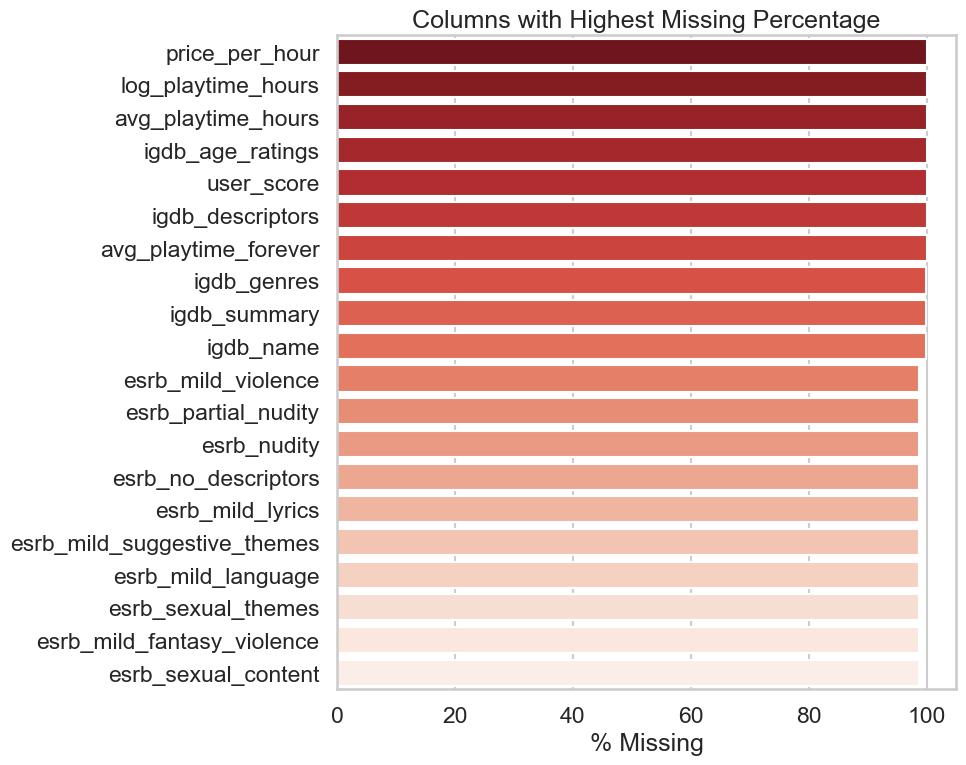

In [13]:
top_missing = missing.head(20).reset_index().rename(columns={"index": "column"})
plt.figure(figsize=(10, 8))
sns.barplot(data=top_missing, x="missing_pct", y="column", palette="Reds_r")
plt.title("Columns with Highest Missing Percentage")
plt.xlabel("% Missing")
plt.ylabel("")
plt.tight_layout()
plt.show()

## Engagement Distribution (Avg Playtime)

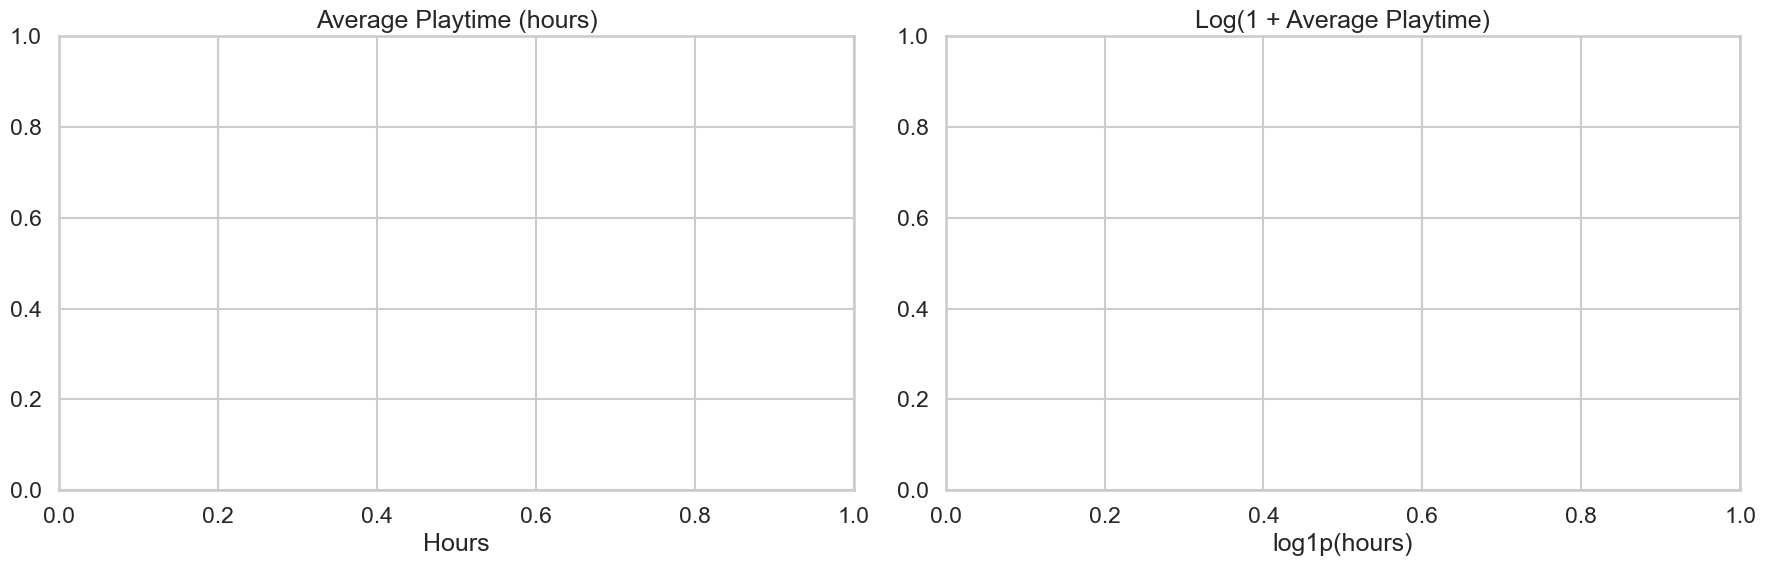

In [14]:
fig, axes = plt.subplots(1, 2, figsize=(18, 6))
valid_playtime = df["avg_playtime_hours"].dropna()

sns.histplot(valid_playtime, bins=50, ax=axes[0], color="#1f77b4")
axes[0].set_title("Average Playtime (hours)")
axes[0].set_xlabel("Hours")

sns.histplot(df["log_playtime_hours"].dropna(), bins=50, ax=axes[1], color="#ff7f0e")
axes[1].set_title("Log(1 + Average Playtime)")
axes[1].set_xlabel("log1p(hours)")

plt.tight_layout()
plt.show()

## Price vs. Engagement

/var/folders/n4/54054b_d0hx5wrdqsn2t46bm0000gn/T/ipykernel_72394/1802727360.py:7: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(
/var/folders/n4/54054b_d0hx5wrdqsn2t46bm0000gn/T/ipykernel_72394/1802727360.py:18: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title="ESRB", bbox_to_anchor=(1.02, 1), loc="upper left")


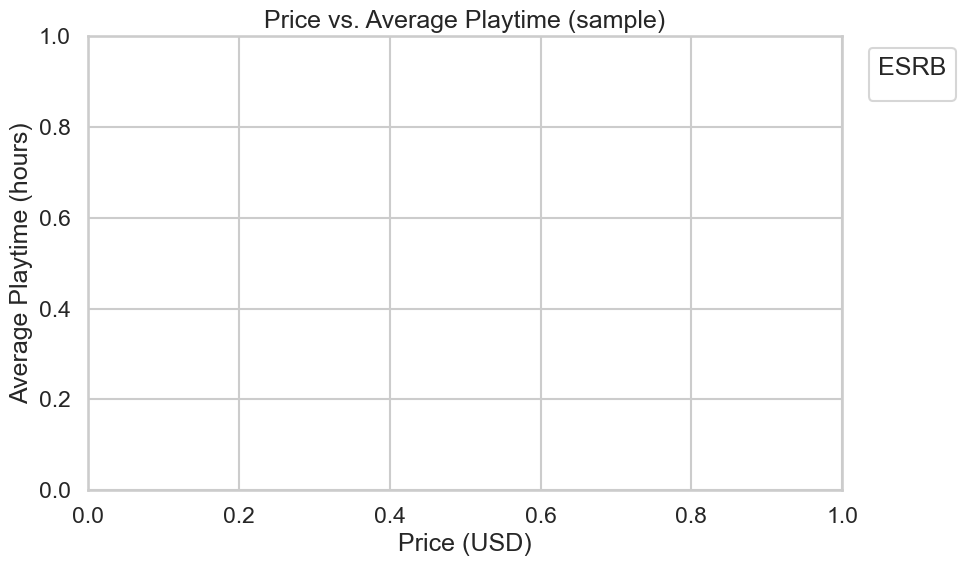

In [15]:
scatter_cols = ["price_usd", "avg_playtime_hours", "esrb_maturity_rating_clean"]
scatter_df = df[scatter_cols].dropna()
if len(scatter_df) > 6000:
    scatter_df = scatter_df.sample(6000, random_state=RANDOM_STATE)

plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=scatter_df,
    x="price_usd",
    y="avg_playtime_hours",
    hue="esrb_maturity_rating_clean",
    alpha=0.6,
    palette="viridis",
)
plt.title("Price vs. Average Playtime (sample)")
plt.xlabel("Price (USD)")
plt.ylabel("Average Playtime (hours)")
plt.legend(title="ESRB", bbox_to_anchor=(1.02, 1), loc="upper left")
plt.tight_layout()
plt.show()

## ESRB Coverage & Impact

/var/folders/n4/54054b_d0hx5wrdqsn2t46bm0000gn/T/ipykernel_72394/3255720643.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=rating_counts.index, y=rating_counts.values, palette="deep")


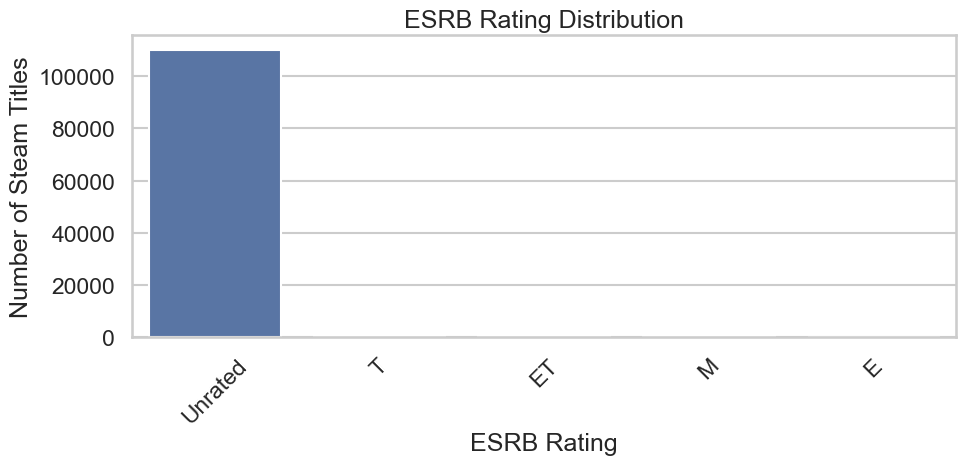

In [16]:
rating_counts = df["esrb_maturity_rating_clean"].value_counts().sort_values(ascending=False)
plt.figure(figsize=(10, 5))
sns.barplot(x=rating_counts.index, y=rating_counts.values, palette="deep")
plt.title("ESRB Rating Distribution")
plt.ylabel("Number of Steam Titles")
plt.xlabel("ESRB Rating")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

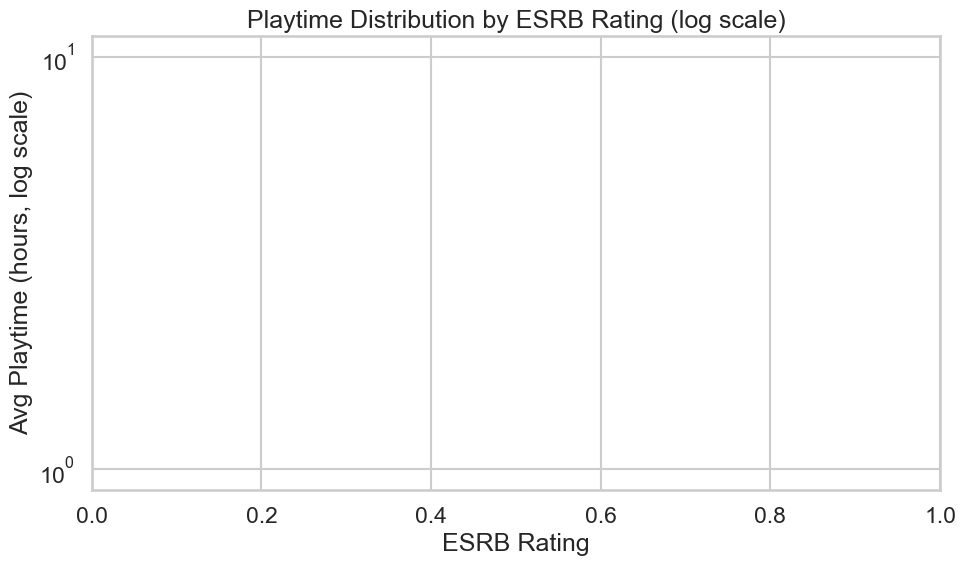

In [17]:
box_cols = ["esrb_maturity_rating_clean", "avg_playtime_hours"]
box_df = df[box_cols].dropna()
major_ratings = rating_counts.head(6).index
box_df = box_df[box_df["esrb_maturity_rating_clean"].isin(major_ratings)]
plt.figure(figsize=(10, 6))
sns.boxplot(
    data=box_df,
    x="esrb_maturity_rating_clean",
    y="avg_playtime_hours",
    palette="Set2",
)
plt.yscale("log")
plt.title("Playtime Distribution by ESRB Rating (log scale)")
plt.xlabel("ESRB Rating")
plt.ylabel("Avg Playtime (hours, log scale)")
plt.tight_layout()
plt.show()

## Steam Achievements vs. Playtime

In [18]:
ach_cols = [
    "achievement_achievement_score_mean",
    "achievement_player_completion_pct_mean",
    "avg_playtime_hours",
]
ach_df = df[ach_cols].dropna()

plt.figure(figsize=(10, 6))
sns.regplot(
    data=ach_df,
    x="achievement_achievement_score_mean",
    y="avg_playtime_hours",
    scatter_kws={"alpha": 0.3},
    line_kws={"color": "#d62728"},
)
plt.yscale("log")
plt.title("Achievement Difficulty vs. Avg Playtime")
plt.xlabel("Mean Achievement Score")
plt.ylabel("Avg Playtime (hours, log scale)")
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 6))
sns.regplot(
    data=ach_df,
    x="achievement_player_completion_pct_mean",
    y="avg_playtime_hours",
    scatter_kws={"alpha": 0.3},
    line_kws={"color": "#2ca02c"},
)
plt.yscale("log")
plt.title("Achievement Completion % vs. Avg Playtime")
plt.xlabel("Mean Completion Percentage")
plt.ylabel("Avg Playtime (hours, log scale)")
plt.tight_layout()
plt.show()

ValueError: Data has no positive values, and therefore cannot be log-scaled.

Error in callback <function _draw_all_if_interactive at 0x115a1cea0> (for post_execute), with arguments args (),kwargs {}:


ValueError: Data has no positive values, and therefore cannot be log-scaled.

ValueError: Data has no positive values, and therefore cannot be log-scaled.

<Figure size 1000x600 with 1 Axes>

## Correlation Heatmap (Numeric Features)

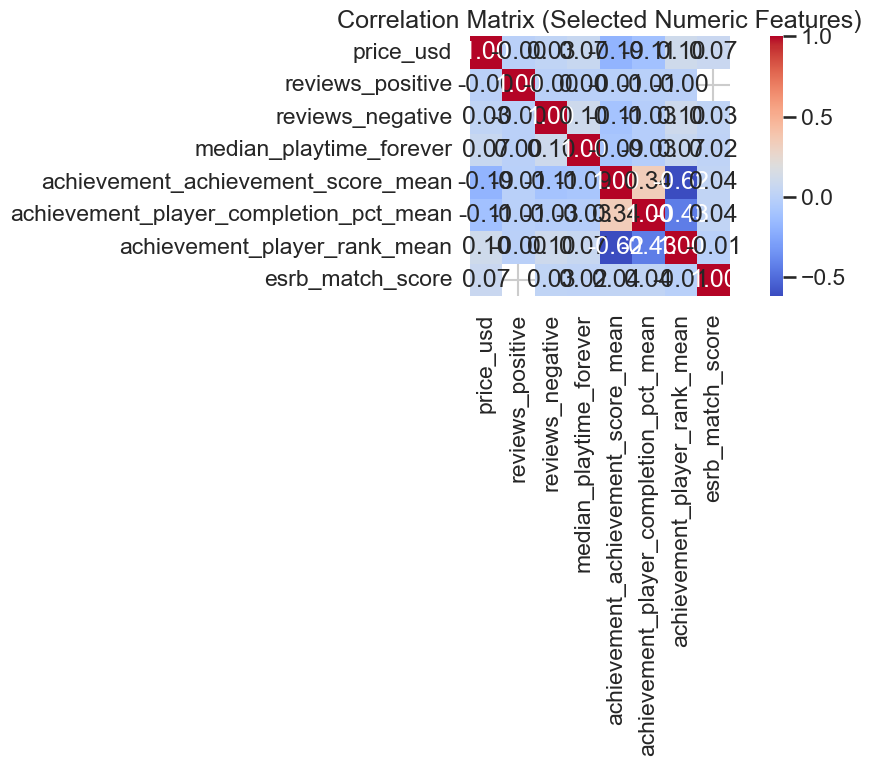

In [19]:
heatmap_cols = [
    "price_usd",
    "user_score",
    "reviews_positive",
    "reviews_negative",
    "avg_playtime_hours",
    "median_playtime_forever",
    "achievement_achievement_score_mean",
    "achievement_player_completion_pct_mean",
    "achievement_player_rank_mean",
    "esrb_match_score",
]
heatmap_df = df[heatmap_cols].dropna(axis=1, how="all")
corr = heatmap_df.corr()
plt.figure(figsize=(12, 8))
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm", square=True)
plt.title("Correlation Matrix (Selected Numeric Features)")
plt.tight_layout()
plt.show()

## IGDB Descriptors & Genres Coverage

In [20]:
def explode_semicolon(series):
    tokens = (
        series.dropna()
        .str.split(";")
        .explode()
        .str.strip()
    )
    tokens = tokens[tokens != ""]
    return tokens

descriptor_counts = explode_semicolon(df["igdb_descriptors"]).value_counts().head(15)
genre_counts = explode_semicolon(df["igdb_genres"]).value_counts().head(15)

fig, axes = plt.subplots(1, 2, figsize=(18, 6))
sns.barplot(
    x=descriptor_counts.values,
    y=descriptor_counts.index,
    ax=axes[0],
    palette="mako",
)
axes[0].set_title("Top IGDB Content Descriptors")
axes[0].set_xlabel("Count")
axes[0].set_ylabel("")

sns.barplot(
    x=genre_counts.values,
    y=genre_counts.index,
    ax=axes[1],
    palette="rocket",
)
axes[1].set_title("Top IGDB Genres")
axes[1].set_xlabel("Count")
axes[1].set_ylabel("")

plt.tight_layout()
plt.show()

AttributeError: Can only use .str accessor with string values!

## Steam Tags & Genres Snapshot

/var/folders/n4/54054b_d0hx5wrdqsn2t46bm0000gn/T/ipykernel_72394/3932790542.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=primary_genre_counts.values, y=primary_genre_counts.index, ax=axes[0], palette="Blues_r")
/var/folders/n4/54054b_d0hx5wrdqsn2t46bm0000gn/T/ipykernel_72394/3932790542.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=tag_counts.values, y=tag_counts.index, ax=axes[1], palette="Greens_r")


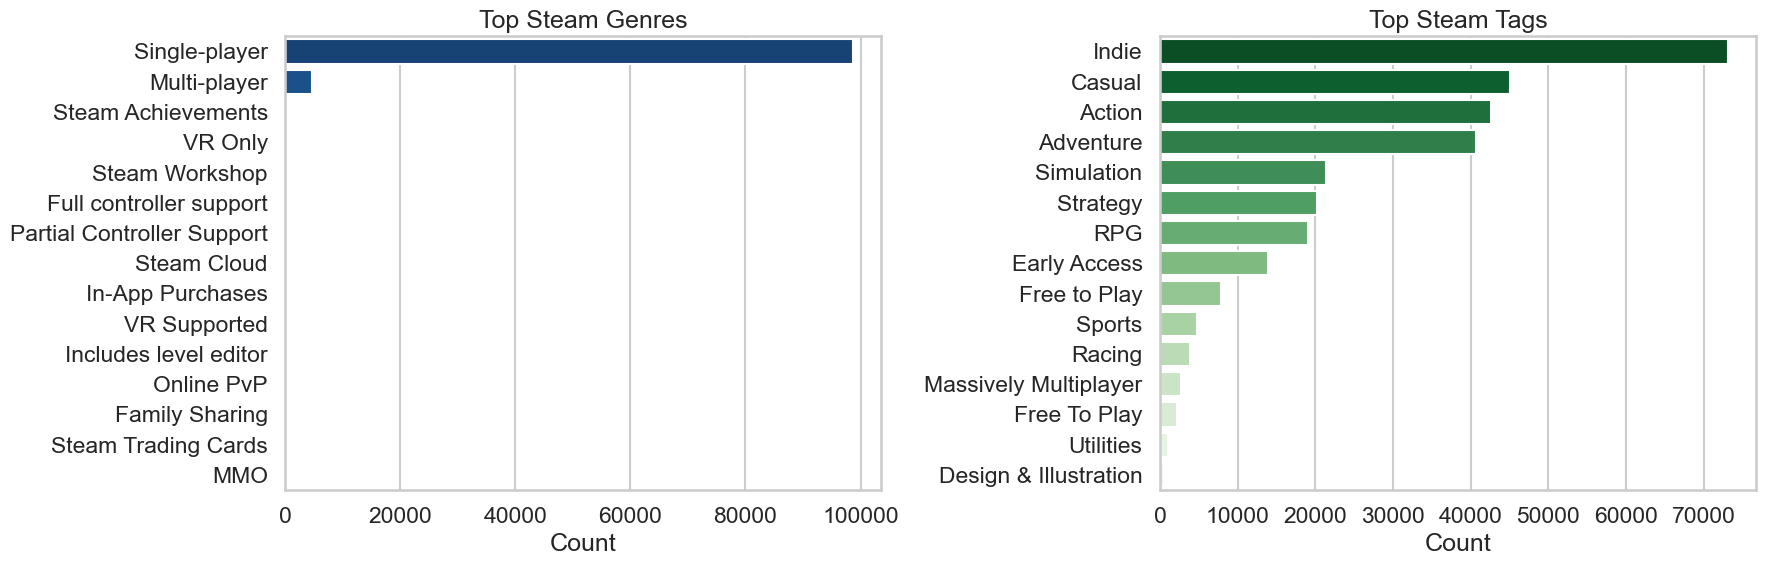

In [21]:
tag_tokens = explode_semicolon(df["tags"].str.replace(",", ";"))
tag_counts = tag_tokens.value_counts().head(15)
primary_genre_counts = df["primary_genre"].value_counts().head(15)

fig, axes = plt.subplots(1, 2, figsize=(18, 6))
sns.barplot(x=primary_genre_counts.values, y=primary_genre_counts.index, ax=axes[0], palette="Blues_r")
axes[0].set_title("Top Steam Genres")
axes[0].set_xlabel("Count")
axes[0].set_ylabel("")

sns.barplot(x=tag_counts.values, y=tag_counts.index, ax=axes[1], palette="Greens_r")
axes[1].set_title("Top Steam Tags")
axes[1].set_xlabel("Count")
axes[1].set_ylabel("")
plt.tight_layout()
plt.show()

## Modeling Checklist
- Target: `avg_playtime_forever` / `avg_playtime_hours` (consider log-transform).
- Candidate numeric predictors: pricing, review counts, achievement aggregates, IGDB/Steam counts.
- Categorical signals: `esrb_maturity_rating_clean`, `primary_genre`, `primary_tag`, IGDB descriptors.
- Next notebook can vectorize tags/descriptors, split train/test, and train RandomForest or XGBoost; add SHAP later for explainability.